# Stochastic Gradient Descent

## Reference
- https://www.geeksforgeeks.org/identifying-handwritten-digits-using-logistic-regression-pytorch/
- Thanks to https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

- Using https://pytorch.org/docs/stable/nn.html#crossentropyloss as a loss function and a linear model which for image x produces Wx+b  (the same as in my Jupiter notebook) train the ML model as follow:

- use .cuda() to make it faster -- note that you have to have both w,b in GPU and also the images have to be on GPU

- use minibatch of size 50, 100, 200 and run it for 10 epochs (1 epoch is when you touch each example once, hence in our case with batch size 50 it is 60000/50 iterations -- this should be quite fast

- experiment with various "fixed" learning rates -- one can try  $ \gamma=2^{-10}, 2^{-9}, ..., 1, 2, 4, 2^{10}  $ -- some of them will have a slow convergence and some of them will even diverge

- For each BS show how $F(x_k)$ changed after each epoch, also do not forget to compute $F(x_0)$. Also do NOT compute the function value after each iteration, just after each EPOCH.

- Show the graph for the 3 BS runs with the best $ \gamma $

- For a point which you obtain after 10 epochs (just one point, do not need to worry about this too much), compute a full gradient, let's call it $g_f $
now compute 100 different stochastic gradients $g^i$ with minibatch "b" and let's estimate the "variance" of the stochastic gradient as 

$$
V(b) = \frac1{100} \sum_{i=1}^{100}  \| g^i - g_f \|^2  for  b = 1, 2, 4, 8, .... 1024
$$
- Make a plot of V(b)


### This is a simple process of Gradient Descent Algorithm.
1. Initialize weight w and bias b to any random numbers.
2. Pick a value for the learning rate α. The learning rate determines how big the step would be on each iteration.
- If α is very small, it would take long time to converge and become computationally expensive.
- If α is large, it may fail to converge and overshoot the minimum.
3. Make sure to scale the data if it’s on a very different scales. If we don’t scale the data, the level curves (contours) would be narrower and taller which means it would take longer time to converge.
4. On each iteration, take the partial derivative of the cost function J(w) w.r.t each parameter (gradient)

We’ll cover gradient descent algorithm and its variants: Batch Gradient Descent, Mini-batch Gradient Descent, and Stochastic Gradient Descent.

<h2>Preparation</h2>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib
from torch.autograd import Variable
# thanks to https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

<h2 id="Makeup_Data">Make Some Data</h2>

First, we'll create some artificial data in a dataset class. The class will include the option to produce training data or validation data. The training data will include outliers.

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10000)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


<h2 id="LR_Loader_Cost">Create a Linear Regression Object,  Data Loader, and Criterion Function</h2>

In [0]:
# Create a linear regression model class
from torch import nn, optim

class linear_regression(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

In [0]:
model = linear_regression(28*28, 10)
model.cuda()

linear_regression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
print(torch.cuda.is_available())

True


In [0]:
# Create a stochastic gradient descent optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Create a loss function
criterion = nn.CrossEntropyLoss()

In [0]:
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).cuda(), Variable(target).cuda()
        # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        net_out = model(data).cuda()
        loss = criterion(net_out, target)
        print(loss.item())
        break;
    break;    

2.3062825202941895


In [0]:
# run the main training loop
for epoch in range(5):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).cuda(), Variable(target).cuda()
        # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        net_out = model(data).cuda()
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1200 == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(epoch+1, loss.item()))

Train Epoch: 1 Loss: 2.306283
Train Epoch: 2 Loss: 0.619052
Train Epoch: 3 Loss: 0.499743
Train Epoch: 4 Loss: 0.446811
Train Epoch: 5 Loss: 0.414176


In [0]:
# run a test loop
with torch.no_grad():
    test_loss = 0
    correct = 0
    for data, target in validation_loader:
        data, target = Variable(data).cuda(), Variable(target).cuda()
        data = data.view(-1, 28 * 28)
        net_out = model(data).cuda()
        # sum up batch loss
        test_loss += criterion(net_out, target).item()
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data).sum()
print('Test loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss, 100. * correct / len(validation_loader.dataset)))

Test loss: 0.3606, Accuracy: 90%


<h2 id="LR_Hyper">Different learning rates and Data Structures to Store results for different Hyperparameters</h2>
Create a list with different learning rates and a tensor (can be a list) for the training and validating cost/total loss. Include the list MODELS, which stores the training model for every value of the learning rate.

In [0]:
# Create Learning Rate list, the error lists and the MODELS list
learning_rates=[2**-10, 2**-9, 2**-8, 2**-7, 2**-6, 2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10]

train_error_50 = torch.zeros(len(learning_rates))
validation_error_50 = torch.zeros(len(learning_rates))

MODELS=[]

<h2 id="Model">Train different models  for different Hyperparameters</h2>
Try different values of learning rates, perform stochastic gradient descent, and save the results on the training data and validation data. Finally, save each model in a list.

In [0]:
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).cuda(), Variable(target).cuda()
        # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        net_out = model(data).cuda()
        loss = criterion(net_out, target)
        print(batch_idx)
        print(loss.item())
        break;
    break;   

0
0.3909375071525574


In [0]:
# Define the train model function and train the model
def train_model_with_lr (iter, lr_list):    
    # iterate through different learning rates 
    for i, lr in enumerate(lr_list):
        print("################################################")
        print('Learning rate: {}'.format(lr))
        model = linear_regression(28*28, 10).cuda()
        optimizer = optim.SGD(model.parameters(), lr = lr)
        for epoch in range(iter):  
            # run the main training loop
            loss_50 = 0          
            for batch_i, (data, target) in enumerate(train_loader):
                data, target = Variable(data).cuda(), Variable(target).cuda()
                # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
                data = data.view(-1, 28*28)                
                net_out = model(data).cuda()
                loss_50 = criterion(net_out, target)
                if batch_i == 0 and epoch == 0:
                    print('The intial loss value:',loss_50.item()) 
                loss_50.backward()
                optimizer.step()
                optimizer.zero_grad()
                if batch_i % 1200 == 0:
                    print('Train Epoch: {} Loss: {:.6f}'.format(epoch+1, loss_50.item()))
            # run a test loop
            model.eval()
            with torch.no_grad():
                test_loss_50 = 0
                correct = 0            
                for data, target in validation_loader:
                    data, target = Variable(data).cuda(), Variable(target).cuda()
                    data = data.view(-1, 28 * 28)
                    net_out = model(data).cuda()
                    # sum up batch loss
                    test_loss_50 += criterion(net_out, target)#.item()
                    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
                    correct += pred.eq(target.data).sum()
                print('Validation loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss_50, 100. * correct / len(validation_loader.dataset)))
        train_error_50[i] = loss_50.item()
        validation_error_50[i] = test_loss_50.item()
        MODELS.append(model)      

train_model_with_lr(10, learning_rates)

################################################
Learning rate: 0.0009765625
The intial loss value: 2.3076601028442383
Train Epoch: 1 Loss: 2.307660
Validation loss: 1.4685, Accuracy: 77%
Train Epoch: 2 Loss: 1.513020
Validation loss: 1.0994, Accuracy: 82%
Train Epoch: 3 Loss: 1.164247
Validation loss: 0.9118, Accuracy: 84%
Train Epoch: 4 Loss: 0.981748
Validation loss: 0.8001, Accuracy: 85%
Train Epoch: 5 Loss: 0.870607
Validation loss: 0.7258, Accuracy: 85%
Train Epoch: 6 Loss: 0.795576
Validation loss: 0.6726, Accuracy: 86%
Train Epoch: 7 Loss: 0.741201
Validation loss: 0.6324, Accuracy: 86%
Train Epoch: 8 Loss: 0.699729
Validation loss: 0.6008, Accuracy: 87%
Train Epoch: 9 Loss: 0.666861
Validation loss: 0.5753, Accuracy: 87%
Train Epoch: 10 Loss: 0.640028
Validation loss: 0.5541, Accuracy: 87%
################################################
Learning rate: 0.001953125
The intial loss value: 2.3123161792755127
Train Epoch: 1 Loss: 2.312316
Validation loss: 1.0975, Accuracy: 81%
Tra

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10000)

In [0]:
# Make learning rate list, the error lists for batchsize 100
learning_rates=[2**-10, 2**-9, 2**-8, 2**-7, 2**-6, 2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10]

train_error_100 = torch.zeros(len(learning_rates))
validation_error_100 = torch.zeros(len(learning_rates))

MODELS=[]

In [0]:
# Define the train model function and train the model
def train_model_with_lr (iter, lr_list):    
    # iterate through different learning rates 
    for i, lr in enumerate(lr_list):
        print("################################################")
        print('Learning rate: {}'.format(lr))
        model = linear_regression(28*28, 10).cuda()
        optimizer = optim.SGD(model.parameters(), lr = lr)
        for epoch in range(iter):  
            # run the main training loop
            loss_100 = 0          
            for batch_i, (data, target) in enumerate(train_loader):
                data, target = Variable(data).cuda(), Variable(target).cuda()
                # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
                data = data.view(-1, 28*28)
                optimizer.zero_grad()
                net_out = model(data).cuda()
                loss_100 = criterion(net_out, target)
                if batch_i == 0 and epoch == 0:
                    print('The intial loss value:',loss_100.item()) 
                loss_100.backward()
                optimizer.step()
                if batch_i % 600 == 0:
                    print('Train Epoch: {} Loss: {:.6f}'.format(epoch+1, loss_100.item()))
            # run a test loop
            model.eval()
            with torch.no_grad():
                test_loss_100 = 0
                correct = 0            
                for data, target in validation_loader:
                    data, target = Variable(data).cuda(), Variable(target).cuda()
                    data = data.view(-1, 28 * 28)
                    net_out = model(data).cuda()
                    # sum up batch loss
                    test_loss_100 += criterion(net_out, target)#.item()
                    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
                    correct += pred.eq(target.data).sum()
                print('Test Average loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss_100, 100. * correct / len(validation_loader.dataset)))
        train_error_100[i] = loss_100.item()
        validation_error_100[i] = test_loss_100.item()
        MODELS.append(model)      

train_model_with_lr(10, learning_rates)

################################################
Learning rate: 0.0009765625
The intial loss value: 2.3217759132385254
Train Epoch: 1 Loss: 2.321776
Test Average loss: 1.7938, Accuracy: 70%
Train Epoch: 2 Loss: 1.779359
Test Average loss: 1.4621, Accuracy: 77%
Train Epoch: 3 Loss: 1.444581
Test Average loss: 1.2442, Accuracy: 80%
Train Epoch: 4 Loss: 1.227359
Test Average loss: 1.0953, Accuracy: 82%
Train Epoch: 5 Loss: 1.079805
Test Average loss: 0.9886, Accuracy: 83%
Train Epoch: 6 Loss: 0.974501
Test Average loss: 0.9089, Accuracy: 84%
Train Epoch: 7 Loss: 0.895979
Test Average loss: 0.8471, Accuracy: 84%
Train Epoch: 8 Loss: 0.835258
Test Average loss: 0.7979, Accuracy: 85%
Train Epoch: 9 Loss: 0.786885
Test Average loss: 0.7576, Accuracy: 85%
Train Epoch: 10 Loss: 0.747398
Test Average loss: 0.7240, Accuracy: 85%
################################################
Learning rate: 0.001953125
The intial loss value: 2.3453145027160645
Train Epoch: 1 Loss: 2.345315
Test Average loss: 1.4

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=200, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10000)

In [0]:
# # Make learning rate list, the error lists for batchsize 200
learning_rates=[2**-10, 2**-9, 2**-8, 2**-7, 2**-6, 2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10]

train_error_200 = torch.zeros(len(learning_rates))
validation_error_200 = torch.zeros(len(learning_rates))

MODELS=[]

In [0]:
# Define the train model function and train the model

def train_model_with_lr (iter, lr_list):    
    # iterate through different learning rates 
    for i, lr in enumerate(lr_list):
        print("################################################")
        print('Learning rate: {}'.format(lr))
        model = linear_regression(28*28, 10).cuda()
        optimizer = optim.SGD(model.parameters(), lr = lr)
        for epoch in range(iter):  
            # run the main training loop
            loss_200 = 0          
            for batch_i, (data, target) in enumerate(train_loader):
                data, target = Variable(data).cuda(), Variable(target).cuda()
                # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
                data = data.view(-1, 28*28)
                optimizer.zero_grad()
                net_out = model(data).cuda()
                loss_200 = criterion(net_out, target)
                if batch_i == 0 and epoch == 0:
                    print('The intial loss value:',loss_200.item()) 
                loss_200.backward()
                optimizer.step()
                if batch_i % 300 == 0:
                    print('Train Epoch: {} Loss: {:.6f}'.format(epoch+1, loss_200.item()))
            # run a test loop
            model.eval()
            with torch.no_grad():
                test_loss_200 = 0
                correct = 0            
                for data, target in validation_loader:
                    data, target = Variable(data).cuda(), Variable(target).cuda()
                    data = data.view(-1, 28 * 28)
                    net_out = model(data).cuda()
                    # sum up batch loss
                    test_loss_200 += criterion(net_out, target)#.item()
                    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
                    correct += pred.eq(target.data).sum()
                print('Test loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss_200, 100. * correct / len(validation_loader.dataset)))
        train_error_200[i] = loss_200.item()
        validation_error_200[i] = test_loss_200.item()
        MODELS.append(model)      

train_model_with_lr(10, learning_rates)

################################################
Learning rate: 0.0009765625
The intial loss value: 2.3237876892089844
Train Epoch: 1 Loss: 2.323788
Test loss: 2.0214, Accuracy: 53%
Train Epoch: 2 Loss: 2.010339
Test loss: 1.7910, Accuracy: 69%
Train Epoch: 3 Loss: 1.778818
Test loss: 1.6076, Accuracy: 75%
Train Epoch: 4 Loss: 1.597589
Test loss: 1.4602, Accuracy: 77%
Train Epoch: 5 Loss: 1.453676
Test loss: 1.3410, Accuracy: 79%
Train Epoch: 6 Loss: 1.338131
Test loss: 1.2434, Accuracy: 80%
Train Epoch: 7 Loss: 1.244181
Test loss: 1.1628, Accuracy: 81%
Train Epoch: 8 Loss: 1.166748
Test loss: 1.0952, Accuracy: 82%
Train Epoch: 9 Loss: 1.102060
Test loss: 1.0380, Accuracy: 82%
Train Epoch: 10 Loss: 1.047328
Test loss: 0.9890, Accuracy: 83%
################################################
Learning rate: 0.001953125
The intial loss value: 2.3084604740142822
Train Epoch: 1 Loss: 2.308460
Test loss: 1.7965, Accuracy: 68%
Train Epoch: 2 Loss: 1.800764
Test loss: 1.4673, Accuracy: 75%
Train 

## View the Results

In [0]:
np.array(learning_rates)

array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01, 3.200000e+01,
       6.400000e+01, 1.280000e+02, 2.560000e+02, 5.120000e+02,
       1.024000e+03])

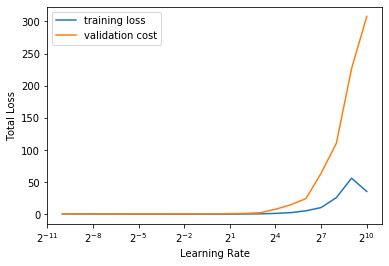

In [0]:
fig, ax = plt.subplots()
plt.semilogx(np.array(learning_rates), train_error_50.cpu().numpy(), label = 'training loss')
plt.semilogx(np.array(learning_rates), validation_error_50.cpu().numpy(), label = 'validation cost')
ax.set_xscale('log', basex=2)
plt.ylabel('Total Loss')
plt.xlabel('Learning Rate')
plt.legend()
plt.show()

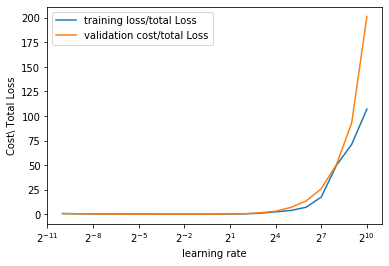

In [0]:
# Plot the training loss and validation loss
# plt.plot(np.array(learning_rates), train_error.cpu().numpy(), label = 'training loss/total Loss')
# plt.plot(np.array(learning_rates), validation_error.cpu().numpy(), label = 'validation cost/total Loss')
fig, ax = plt.subplots()
plt.semilogx(np.array(learning_rates), train_error_100.cpu().numpy(), label = 'training loss/total Loss')
plt.semilogx(np.array(learning_rates), validation_error_100.cpu().numpy(), label = 'validation cost/total Loss')
ax.set_xscale('log', basex=2)
plt.ylabel('Cost\ Total Loss')
plt.xlabel('learning rate')
plt.legend()
plt.show()

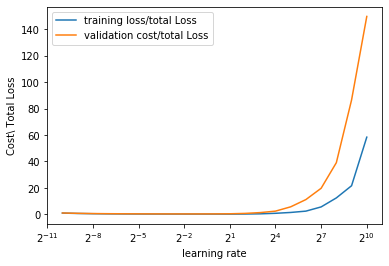

In [0]:
# Plot the training loss and validation loss
# plt.plot(np.array(learning_rates), train_error.cpu().numpy(), label = 'training loss/total Loss')
# plt.plot(np.array(learning_rates), validation_error.cpu().numpy(), label = 'validation cost/total Loss')
fig, ax = plt.subplots()
plt.semilogx(np.array(learning_rates), train_error_200.cpu().numpy(), label = 'training loss/total Loss')
plt.semilogx(np.array(learning_rates), validation_error_200.cpu().numpy(), label = 'validation cost/total Loss')
ax.set_xscale('log', basex=2)
plt.ylabel('Cost\ Total Loss')
plt.xlabel('learning rate')
plt.legend()
plt.show()

In [0]:
min(train_error_50)

tensor(0.0827)

In [0]:
min(train_error_100)

tensor(0.2783)

In [0]:
train_error_100.argmin()

tensor(9)

In [0]:
min(train_error_200)

tensor(0.1318)

In [0]:
train_error_200.argmin()

tensor(11)

In [0]:
print(learning_rates[train_error_50.argmin()]) # Batch size: 50
print(learning_rates[train_error_100.argmin()]) # Batch size: 100
print(learning_rates[train_error_200.argmin()]) # # Batch size: 200

1
0.5
2


In [0]:
best_batch = [min(train_error_50).cpu().numpy(), min(train_error_100).cpu().numpy(), min(train_error_200).cpu().numpy()]
best_batch

[array(0.08265018, dtype=float32),
 array(0.27827293, dtype=float32),
 array(0.1318173, dtype=float32)]

In [0]:
learning_rates[train_error_50.argmin()]

([<matplotlib.axis.XTick at 0x7fd128490b70>,
 <a list of 3 Text xticklabel objects>)

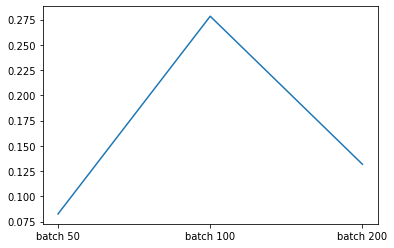

In [0]:
plt.plot(best_batch)
positions = (0, 1, 2)
labels = ("batch 50: learning 1", "batch 100", "batch 200")
plt.xticks(positions, labels)

# Show the graph for the 3 BS runs with the best  𝛾 

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10000)

# Define the train model function and train the model

# iterate through different learning rates 
lr = 1
print("################################################")
print('Learning rate: {}'.format(lr))
model = linear_regression(28*28, 10).cuda()
optimizer = optim.SGD(model.parameters(), lr = lr)
loss_50_ = []
test_loss_50_ = []
for epoch in range(10):
     
    for batch_i, (data, target) in enumerate(train_loader):
        data, target = Variable(data).cuda(), Variable(target).cuda()
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        net_out = model(data).cuda()
        loss = criterion(net_out, target)
        if batch_i == 0 and epoch == 0:
            print('The intial loss value:',loss.item()) 
        loss.backward()
        optimizer.step()
        if batch_i % 1200 == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(epoch+1, loss.item()))
        
    model.eval()
    with torch.no_grad():
        
        correct = 0            
        for data, target in validation_loader:
            data, target = Variable(data).cuda(), Variable(target).cuda()
            data = data.view(-1, 28 * 28)
            net_out = model(data).cuda()
            # sum up batch loss
            test_loss += criterion(net_out, target)#.item()
            pred = net_out.data.max(1)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data).sum()
        print('Test Average loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss, 100. * correct / len(validation_loader.dataset)))
    loss_50_.append(loss.item())
    test_loss_50_.append(test_loss.item())
    MODELS.append(model)      

################################################
Learning rate: 1
The intial loss value: 2.316136121749878
Train Epoch: 1 Loss: 2.316136
Test Average loss: 0.7368, Accuracy: 88%
Train Epoch: 2 Loss: 0.207184
Test Average loss: 1.1610, Accuracy: 89%
Train Epoch: 3 Loss: 0.182615
Test Average loss: 1.5744, Accuracy: 89%
Train Epoch: 4 Loss: 0.173435
Test Average loss: 1.9756, Accuracy: 89%
Train Epoch: 5 Loss: 0.167937
Test Average loss: 2.3663, Accuracy: 90%
Train Epoch: 6 Loss: 0.161883
Test Average loss: 2.7494, Accuracy: 90%
Train Epoch: 7 Loss: 0.155409
Test Average loss: 3.1283, Accuracy: 90%
Train Epoch: 8 Loss: 0.150458
Test Average loss: 3.5051, Accuracy: 90%
Train Epoch: 9 Loss: 0.146675
Test Average loss: 3.8811, Accuracy: 90%
Train Epoch: 10 Loss: 0.143702
Test Average loss: 4.2570, Accuracy: 90%


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10000)

lr = .5
print("################################################")
print('Learning rate: {}'.format(lr))
model = linear_regression(28*28, 10).cuda()
optimizer = optim.SGD(model.parameters(), lr = lr)
loss_100_ = []
test_loss_100_ = []
for epoch in range(10):
    
    for batch_i, (data, target) in enumerate(train_loader):
        data, target = Variable(data).cuda(), Variable(target).cuda()
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        net_out = model(data).cuda()
        loss = criterion(net_out, target)
        if batch_i == 0 and epoch == 0:
            print('The intial loss value:',loss.item()) 
        loss.backward()
        optimizer.step()
        if batch_i % 600 == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(epoch+1, loss.item()))
        
    model.eval()
    with torch.no_grad():
        
        correct = 0            
        for data, target in validation_loader:
            data, target = Variable(data).cuda(), Variable(target).cuda()
            data = data.view(-1, 28 * 28)
            net_out = model(data).cuda()
            # sum up batch loss
            test_loss = criterion(net_out, target)#.item()
            pred = net_out.data.max(1)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data).sum()
        print('Test Average loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss, 100. * correct / len(validation_loader.dataset)))
    loss_100_.append(loss.item())
    test_loss_100_.append(test_loss.item())
    MODELS.append(model)  

################################################
Learning rate: 0.5
The intial loss value: 2.2969770431518555
Train Epoch: 1 Loss: 2.296977
Test Average loss: 0.3242, Accuracy: 90%
Train Epoch: 2 Loss: 0.242263
Test Average loss: 0.3085, Accuracy: 91%
Train Epoch: 3 Loss: 0.217746
Test Average loss: 0.3027, Accuracy: 91%
Train Epoch: 4 Loss: 0.208224
Test Average loss: 0.2996, Accuracy: 91%
Train Epoch: 5 Loss: 0.203350
Test Average loss: 0.2975, Accuracy: 91%
Train Epoch: 6 Loss: 0.200391
Test Average loss: 0.2960, Accuracy: 91%
Train Epoch: 7 Loss: 0.198366
Test Average loss: 0.2949, Accuracy: 91%
Train Epoch: 8 Loss: 0.196856
Test Average loss: 0.2940, Accuracy: 92%
Train Epoch: 9 Loss: 0.195656
Test Average loss: 0.2932, Accuracy: 92%
Train Epoch: 10 Loss: 0.194658
Test Average loss: 0.2927, Accuracy: 92%


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=200, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10000)

lr = 2
print("################################################")
print('Learning rate: {}'.format(lr))
model = linear_regression(28*28, 10).cuda()
optimizer = optim.SGD(model.parameters(), lr = lr)
loss_200_ = []
test_loss_200_ = []
for epoch in range(10):
    
    for batch_i, (data, target) in enumerate(train_loader):
        data, target = Variable(data).cuda(), Variable(target).cuda()
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        net_out = model(data).cuda()
        loss = criterion(net_out, target)
        if batch_i == 0 and epoch == 0:
            print('The intial loss value:',loss.item()) 
        loss.backward()
        optimizer.step()
        if batch_i % 300 == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(epoch+1, loss.item()))
        
    model.eval()
    with torch.no_grad():
        correct = 0            
        for data, target in validation_loader:
            data, target = Variable(data).cuda(), Variable(target).cuda()
            data = data.view(-1, 28 * 28)
            net_out = model(data).cuda()
            # sum up batch loss
            test_loss += criterion(net_out, target)#.item()
            pred = net_out.data.max(1)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data).sum()
        print('Test Average loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss, 100. * correct / len(validation_loader.dataset)))
    loss_200_.append(loss.item())
    test_loss_200_.append(test_loss.item())
    MODELS.append(model)  

################################################
Learning rate: 2
The intial loss value: 2.2917916774749756
Train Epoch: 1 Loss: 2.291792
Test Average loss: 5.1294, Accuracy: 89%
Train Epoch: 2 Loss: 0.325915
Test Average loss: 5.5474, Accuracy: 90%
Train Epoch: 3 Loss: 0.305108
Test Average loss: 5.9554, Accuracy: 90%
Train Epoch: 4 Loss: 0.286195
Test Average loss: 6.3589, Accuracy: 90%
Train Epoch: 5 Loss: 0.278032
Test Average loss: 6.7567, Accuracy: 90%
Train Epoch: 6 Loss: 0.268679
Test Average loss: 7.1502, Accuracy: 90%
Train Epoch: 7 Loss: 0.262362
Test Average loss: 7.5406, Accuracy: 90%
Train Epoch: 8 Loss: 0.257854
Test Average loss: 7.9289, Accuracy: 90%
Train Epoch: 9 Loss: 0.254373
Test Average loss: 8.3153, Accuracy: 90%
Train Epoch: 10 Loss: 0.251496
Test Average loss: 8.7003, Accuracy: 90%


In [0]:
loss_200_

[0.13172079622745514]

<Figure size 432x288 with 0 Axes>

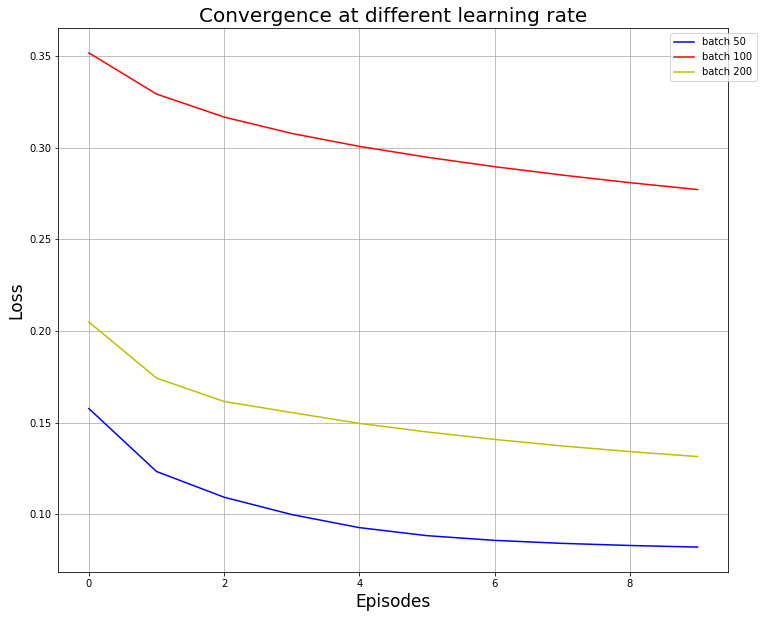

In [0]:
# Plotting convergence at different learning rate
plt.figure()
plt.figure(figsize=[12, 10])
a, = plt.plot(loss_50_,color='b',label='batch 50')
b, = plt.plot(loss_100_,color='r',label='batch 100')
c, = plt.plot(loss_200_,color='y',label='batch 200')
plt.grid(True)
# plt.xlim((0,10))
# plt.ylim((0,500))
plt.title('Convergence at different learning rate',fontsize=20)
plt.xlabel('Episodes',fontsize=17)
plt.ylabel('Loss',fontsize=17)
plt.legend(bbox_to_anchor=(1.05, 1),handles=[a,b,c,],loc='best')

In [0]:
# # # Plot the predictions

# i = 0
# for model, learning_rate in zip(MODELS, learning_rates):
#     yhat = model(validation_loader.dataset)
#     plt.plot(validation_loader.dataset.numpy(), net_out.detach().numpy(), label = 'lr:' + str(learning_rate))
#     print('i', yhat.detach().numpy()[0:3])
# plt.plot(validation_loader.dataset.numpy(), validation_loader.dataset.f.numpy(), 'or', label = 'validation data')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.show()

For a point which you obtain after 10 epochs (just one point, do not need to worry about this too much), compute a full gradient, let's call it $g_f $
now compute 100 different stochastic gradients $g^i$ with minibatch "b" and let's estimate the "variance" of the stochastic gradient as 

$$
V(b) = \frac1{100} \sum_{i=1}^{100}  \| g^i - g_f \|^2  for  b = 1, 2, 4, 8, .... 1024
$$
- Make a plot of V(b)

In [0]:
batch_size = [1,2,4,8,16,32,64,128,256,512,1024]
loss = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=False)
variances = torch.zeros(len(batch_size))

model = linear_regression(28*28, 10)
model.cuda()

# Create a stochastic gradient descent optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Create a loss function
criterion = nn.CrossEntropyLoss()

data, target = iter(train_loader).next()
data, target = Variable(data).cuda(), Variable(target).cuda()
data = data.view(-1, 28*28)
model.zero_grad()
net_out = model.forward(data)
loss = criterion(net_out, target)
loss.backward()

In [0]:
model.parameters

<bound method Module.parameters of linear_regression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)>

In [0]:
fullg_w = model.linear.weight.grad.data.clone()

In [0]:
fullg_w.shape

torch.Size([10, 784])

In [0]:
fullg_w = model.linear.weight.grad.data.clone()
fullg_b = model.linear.bias.grad.data.clone()

In [0]:
for i,b in enumerate(batch_size):
    for _ in range(100):
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=b, shuffle=True)
        data, target = iter(train_loader).next()
        data, target = Variable(data).cuda(), Variable(target).cuda()
        data = data.view(-1, 28*28)
        model.zero_grad()
        net_out = model.forward(data)
        loss = criterion(net_out, target)
        loss.backward()
        
        variances[i] += (model.linear.weight.grad.data.sub(fullg_w).norm()*2 + model.linear.bias.grad.data.sub(fullg_b).norm()*2)/100.

In [0]:
len(variances)

11

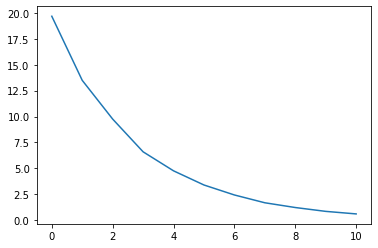

In [0]:
plt.plot(variances)

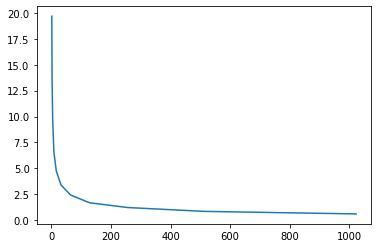

In [0]:
plt.plot(batch_size,variances)